In [10]:
import os
import sys
import traceback
import matplotlib.pyplot as plt
from datetime import datetime

from scipy import signal
from scipy.stats import zscore

import numpy as np
import pandas as pd

import mne
import keras
# from ecgdetectors import Detectors

DATA_DIR = "data/cap-sleep-database-1.0.0"
TARGET_HZ = 64
# ECG_DETECTOR = Detectors(TARGET_HZ)


def load_cap_ecg_data_mne(edf_file, fs_target=50, log=print):
    try:
        raw = mne.io.read_raw_edf(edf_file, preload=False)
        ch_idx = -1
        ch_name = None
        for cname in raw.info.get('ch_names'):
            ch_idx += 1
            if cname.find("ECG") > -1:
                ch_name = cname
                break
        hz = mne.pick_info(raw.info, [ch_idx], verbose=False)['sfreq']
        hz = int(hz)
        raw.pick_channels([ch_name])
        recording = raw.get_data().flatten()
        print(f"channel: {cname}")

    except:
        log(f"Error reading {edf_file}, caused by - {traceback.format_exc()}")
        return
    meta = {
        "hz": hz,
        "dt_signal_start": raw.info.get('meas_date')
    }
    # Down sample to 50Hz
    down_factor = meta["hz"] // fs_target
    target_samples = len(recording) // down_factor
    print(f"{edf_file}, @{meta['hz']}, down_factor:{down_factor}, recording:{recording.shape}, target:{target_samples}")
    recording = signal.resample(recording, target_samples)

    # Read annotation
    labels = []
    return (recording, labels, meta)


def generate_rr_signal(ecg_signal):
    rr_signal = np.zeros((ecg_signal.shape[0]))
    r_peaks = ECG_DETECTOR.pan_tompkins_detector(ecg_signal)
    r_peak_diff = np.diff(r_peaks)
    rr_signal[0:len(r_peak_diff)] = r_peak_diff
    return (r_peaks, rr_signal)


def sample_offset_stm(stm_annot, stm_signal, target_hz=64):
    print(f"tm_annot:{stm_annot}, tm_signal:{stm_signal}, target_hz:{target_hz}")
    tm_annot = datetime.strptime(stm_annot, "%H:%M:%S")
    tm_signal = datetime.strptime(stm_signal, "%H:%M:%S")
    delta_sec = int((tm_annot-tm_signal).total_seconds())
    return delta_sec*target_hz


def stm_annot_start(annot_filepath):
    with open(annot_filepath, "r") as f:
        lines = f.readlines()
    reached_sleep_stage_line = False    
    for line in lines:
        # print(line)
        tokens = line.split("\t")
        if not reached_sleep_stage_line and not line.startswith("Sleep Stage"):
            continue
        if line.startswith("Sleep Stage"):
            reached_sleep_stage_line = True
            continue
        # first annotation line
        s_time = tokens[-4]
        if s_time.find(":") < 0:
            print(f"Invalid timestamp | {line}")
            return None
        break
    return s_time

def edf_to_csv(data_directory):
    # Find and read .edf files and corresponding .txt files for annotation.
    #
    count_file = 0
    ignore_file = 0
    bad_files = []
    record_names = []
    target_data_dir = f"{data_directory}/np_data_{TARGET_HZ}"
    if not os.path.exists(target_data_dir):
        os.makedirs(target_data_dir)

    for f in os.listdir(data_directory):
        if not f.endswith(".edf"):
            continue
        rec_name = f[:-4]  # exclude .edf
        try:
            edf_path = f"{data_directory}/{f}"
            recording, _, meta = load_cap_ecg_data_mne(edf_path, fs_target=TARGET_HZ)
            
            # Annotation does not start from the beginning of a singal, 
            # discard un-annotated initial signal samples.
            # 
            stm_annot_begin = stm_annot_start(edf_path.replace('.edf', '.txt'))

            n_samples_skip = sample_offset_stm(stm_annot_begin, meta["dt_signal_start"].time().strftime("%H:%M:%S"))            
            
            print(
                f"{count_file} | {f} | signal:{recording.shape}, "
                f"offset:{n_samples_skip} samples ({stm_annot_begin}-{meta['dt_signal_start'].time().strftime('%H:%M:%S')}), "
                f"signal*:{len(recording)-n_samples_skip}")
            len_before = len(recording)
            recording = recording[n_samples_skip:]
            assert len(recording) == len_before - n_samples_skip

            record_names.append(rec_name)

            np.savetxt(f"{target_data_dir}/{f.replace('.edf', '.csv')}", recording)
            os.system(f"cp {data_directory}/{f.replace('.edf', '.txt')} {target_data_dir}")

            # rr_signal = generate_rr_signal(recording)
            # print(f"rr_signal")
            # break
        except:
            ignore_file += 1
            print(f"error loading {f}")
            traceback.print_exc(file=sys.stdout)
            bad_files.append(f)
            # Ignore corrupted recording.
            continue
        count_file += 1    
        # break
    print(f"{count_file} files created.")

In [7]:
# Create .csv files from .edf and resample, finally, store in subdirectory 'np_data_{hz}'.
# 
# edf_to_csv(DATA_DIR)

Extracting EDF parameters from /home/mahabib/Documents/py_code/projects/sleep_ecg/data/cap-sleep-database-1.0.0/rbd12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
channel: ECG1-ECG2
data/cap-sleep-database-1.0.0/rbd12.edf, @512, down_factor:8, recording:(16481792,), target:2060224
tm_annot:21:56:54, tm_signal:21:52:54, target_hz:64
0 | rbd12.edf | signal:(2060224,), offset:15360 samples (21:56:54-21:52:54), signal*:2044864
1 files created.


In [27]:
class DataGenerator(keras.utils.Sequence):
    def __init__(
            self, np_data_dir, list_rec_names=None, batch_sz=32, hz=64, n_channels=1, shuffle=False, log=print,
            class_map={
                "S0": 0,
                "S1": 1,
                "S2": 2,
                "S3": 3,
                "S4": 3,
                "REM": 4,
            }
    ):
        self.np_data_dir = np_data_dir
        self.list_rec_names = list_rec_names
        self.batch_sz = batch_sz
        self.hz = hz
        self.class_map = class_map
        self.n_classes = len(class_map)
        self.dim = self.hz * 30  # 30 sec @64Hz
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.log = log
        self.samples_meta = []

        self._init_data_dict()

    def _init_data_dict(self):
        self.log("Initialise meta data of samples")
        reached_sleep_stage_line = False
        for f in os.listdir(self.np_data_dir):
            reached_sleep_stage_line = False
            seg_count = 0
            if not f.endswith(".csv"):
                continue
            rec_name = f[:-4]
            if not rec_name in self.list_rec_names:
                continue            
            self.log(f"Loading {rec_name}...")
            sig_filepath = f"{self.np_data_dir}/{f}"
            ecg_sig = np.loadtxt(sig_filepath, delimiter=",")
            annot_filepath = sig_filepath.replace('.csv', '.txt')
            with open(annot_filepath, "r") as f:
                lines = f.readlines()
            n_seg_est = ecg_sig.shape[0]//self.dim    
            self.log(f"[{rec_name}] {ecg_sig.shape}, n_seg:{n_seg_est}")
            start = 0
            ignored_annots_bad_len, ignored_annots_bad_label = 0, 0
            self.log(f"recording:{ecg_sig.shape}")
            for line in lines:
                # print(line)
                tokens = line.split("\t")
                if not reached_sleep_stage_line and not line.startswith("Sleep Stage"):
                    continue
                if line.startswith("Sleep Stage"):
                    reached_sleep_stage_line = True
                    continue
                # Annotation starts
                try:
                    tok_is_sleep = tokens[-3]
                    if tok_is_sleep.find("SLEEP-") < 0:
                        current_epoch_len = int(tokens[-2])
                        continue
                    label_str = tok_is_sleep.split("-")[-1]
                    label = self.class_map.get(label_str)
                    current_epoch_len = int(tokens[-2])
                except:
                    self.log(f"--> error parsing epoch-len: {tokens[-2]}")
                    ignored_annots_bad_len += 1
                    continue
                if current_epoch_len != 30:  # not a valid sleep epoch
                    ignored_annots_bad_len += 1
                    self.log(f"--> bad length: {current_epoch_len}")
                    # start += (current_epoch_len*self.hz)
                    continue
                if label is None:
                    self.log(
                        f"Ignored label for label_str:{label_str}->{label} >> {line}")
                    ignored_annots_bad_label += 1
                    start += self.dim
                    continue
                end = start + self.dim
                seg = ecg_sig[start : end]
                remaining = len(ecg_sig) - end

                if len(seg) != self.dim:
                    self.log(f"bad seg_sz:{len(seg)} >> {line}")
                    start += self.dim
                    continue

                self.samples_meta.append((rec_name, start, label))    

                # update start
                start += self.dim
                seg_count += 1    

            self.log(
                f"...[{rec_name}], n_seg:{seg_count} out of {n_seg_est} (lags seg:{n_seg_est-seg_count}, "
                f"samples:{(n_seg_est-seg_count)*self.dim}), bad_label: {ignored_annots_bad_label}, bad_len/ignored: {ignored_annots_bad_len}, "
                f"remaining:{remaining}")
        self.log(f"Total sample-meta loaded: {len(self.samples_meta)}")
        self.indexes = range(len(self.samples_meta))

    def __len__(self):
        return int(np.floor(len(self.indexes) / self.batch_sz))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_sz:(index+1)*self.batch_sz]
        X, y = self.__data_generation(batch_indexes)
        return X, y
    
    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_sz, self.dim, self.n_channels))
        y = np.empty((self.batch_sz), dtype=int)

        # Generate data, retrieve from files
        for i, ID in enumerate(list_IDs_temp):
            self.log(f"i:{i} => {self.samples_meta[self.indexes[i]]} | ID:{ID} => {self.samples_meta[self.indexes[ID]]}")
            rec_name, seg_start, label = self.samples_meta[self.indexes[ID]]
            # sig_filepath = os.path.join(self.data_dir, "np_data_64", f"{rec_name}.csv")
            sig_filepath = os.path.join(self.np_data_dir, f"{rec_name}.csv")
            ecg_sig = np.loadtxt(sig_filepath, delimiter=",")
            segment = ecg_sig[seg_start:seg_start+self.dim]
            segment = zscore(segment)  # normalise segment
            X[i,] = segment.reshape((self.dim, 1))
            y[i] = label
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)


In [28]:
training_generator = DataGenerator(np_data_dir="data/cap-sleep-database-1.0.0/np_data_64", list_rec_names=['nfle2'])
# training_generator = DataGenerator(np_data_dir="data/cap-sleep-database-1.0.0/np_data_64", list_rec_names=['nfle2', 'sdb2'])

Initialise meta data of samples
Loading nfle2...
[nfle2] (1877824,), n_seg:978
recording:(1877824,)
...[nfle2], n_seg:975 out of 978 (lags seg:3, samples:5760), bad_label: 0, bad_len/ignored: 0, remaining:5824
Total sample-meta loaded: 975


In [29]:
print("number of batches:", len(training_generator))
batch_x, batch_y = training_generator[0] 
print("batch-data-shape:", batch_x.shape, ", batch_size:", batch_x.shape[0], ", single-item-in-batch:", batch_x[0].shape)

number of batches: 30
i:0 => ('nfle2', 0, 0) | ID:0 => ('nfle2', 0, 0)
i:1 => ('nfle2', 1920, 0) | ID:1 => ('nfle2', 1920, 0)
i:2 => ('nfle2', 3840, 0) | ID:2 => ('nfle2', 3840, 0)
i:3 => ('nfle2', 5760, 0) | ID:3 => ('nfle2', 5760, 0)
i:4 => ('nfle2', 7680, 0) | ID:4 => ('nfle2', 7680, 0)
i:5 => ('nfle2', 9600, 0) | ID:5 => ('nfle2', 9600, 0)
i:6 => ('nfle2', 11520, 0) | ID:6 => ('nfle2', 11520, 0)
i:7 => ('nfle2', 13440, 0) | ID:7 => ('nfle2', 13440, 0)
i:8 => ('nfle2', 15360, 0) | ID:8 => ('nfle2', 15360, 0)
i:9 => ('nfle2', 17280, 1) | ID:9 => ('nfle2', 17280, 1)
i:10 => ('nfle2', 19200, 1) | ID:10 => ('nfle2', 19200, 1)
i:11 => ('nfle2', 21120, 1) | ID:11 => ('nfle2', 21120, 1)
i:12 => ('nfle2', 23040, 1) | ID:12 => ('nfle2', 23040, 1)
i:13 => ('nfle2', 24960, 2) | ID:13 => ('nfle2', 24960, 2)
i:14 => ('nfle2', 26880, 2) | ID:14 => ('nfle2', 26880, 2)
i:15 => ('nfle2', 28800, 2) | ID:15 => ('nfle2', 28800, 2)
i:16 => ('nfle2', 30720, 2) | ID:16 => ('nfle2', 30720, 2)
i:17 => ('nfl

(1920,)


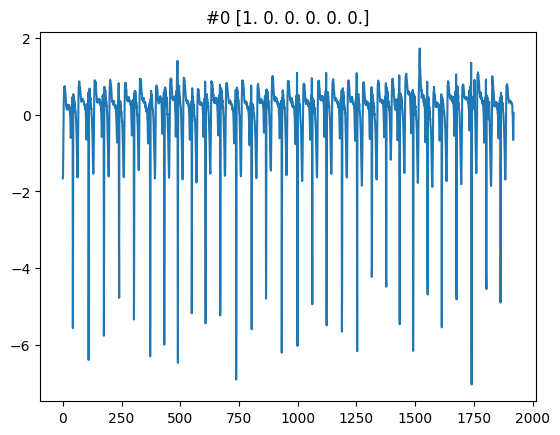

(1920,)


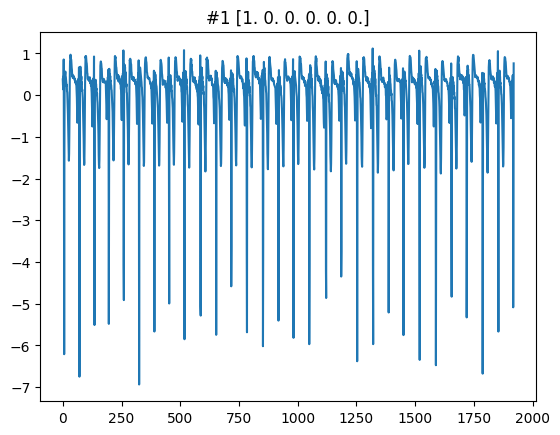

(1920,)


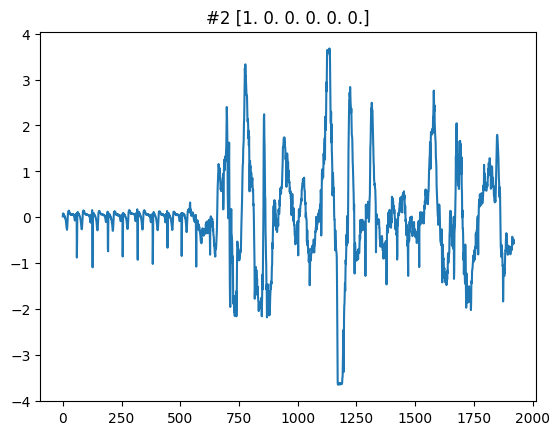

(1920,)


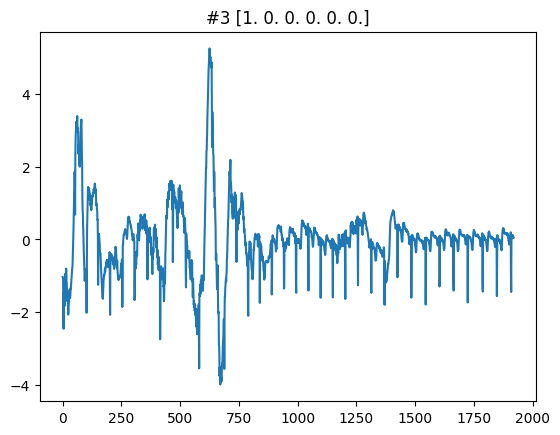

(1920,)


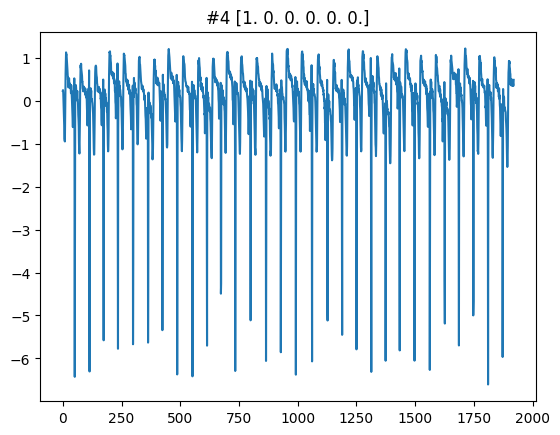

(1920,)


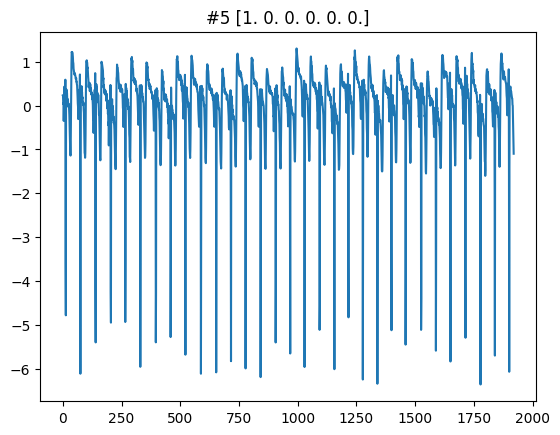

(1920,)


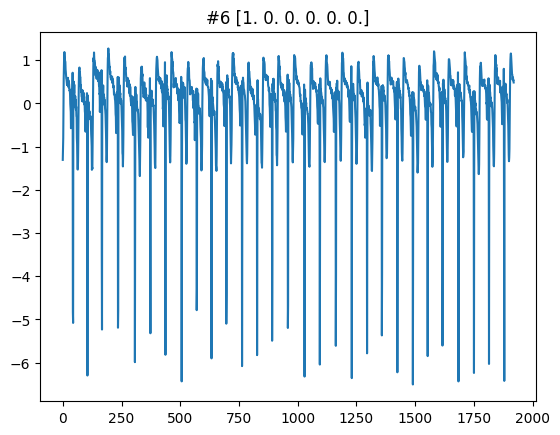

(1920,)


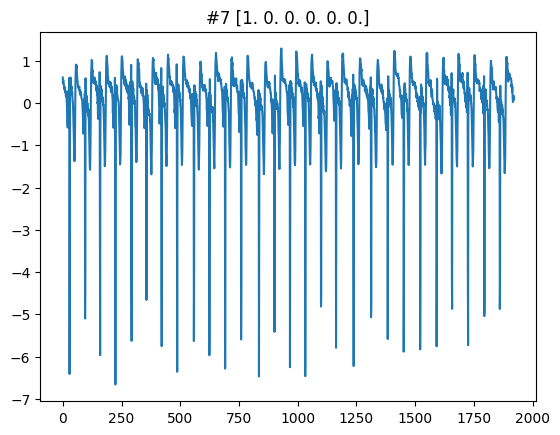

(1920,)


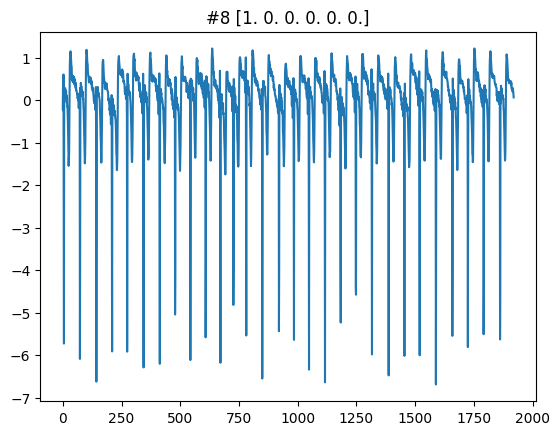

(1920,)


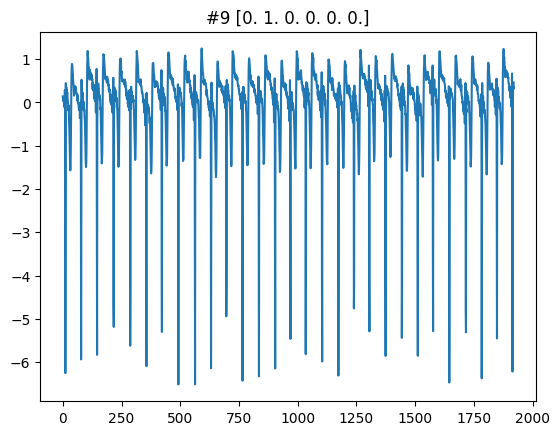

(1920,)


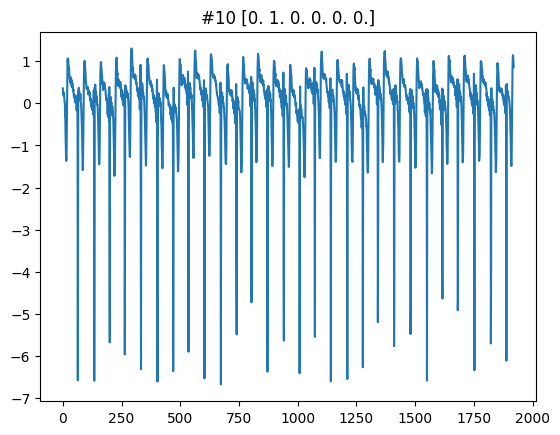

(1920,)


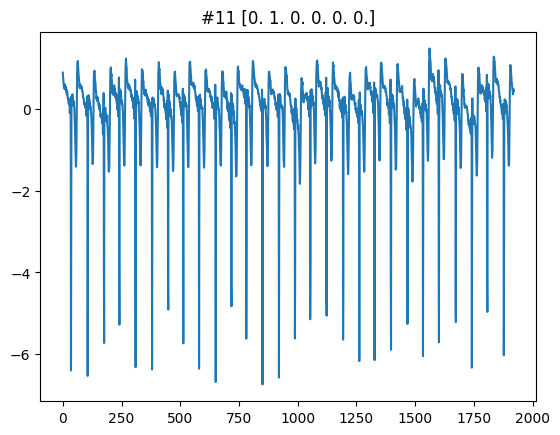

(1920,)


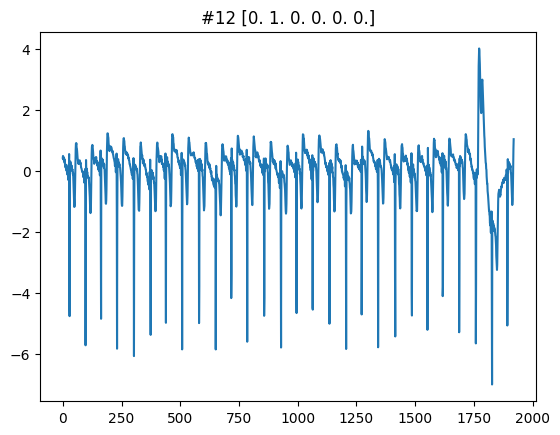

(1920,)


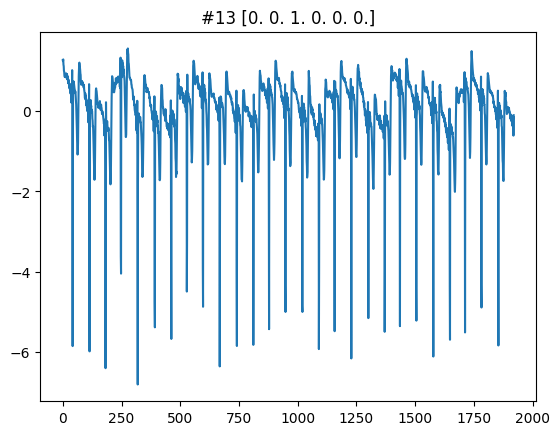

(1920,)


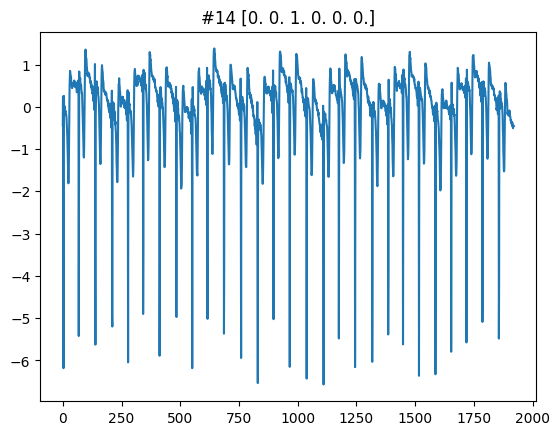

(1920,)


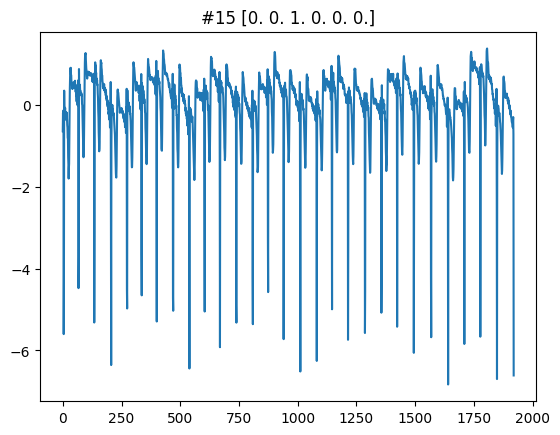

(1920,)


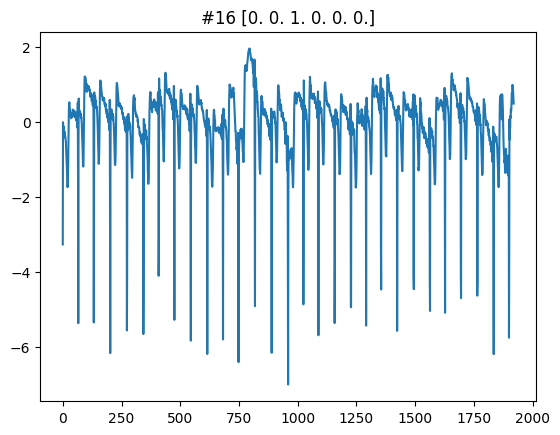

(1920,)


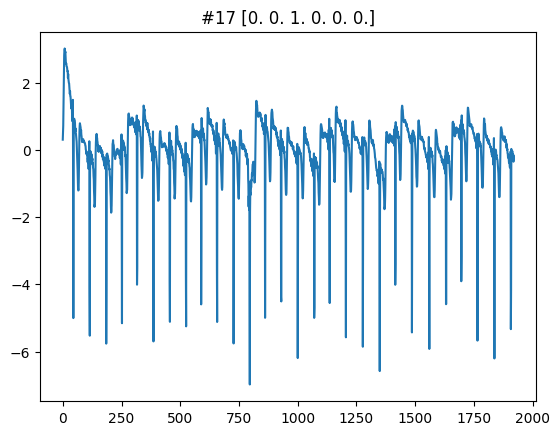

(1920,)


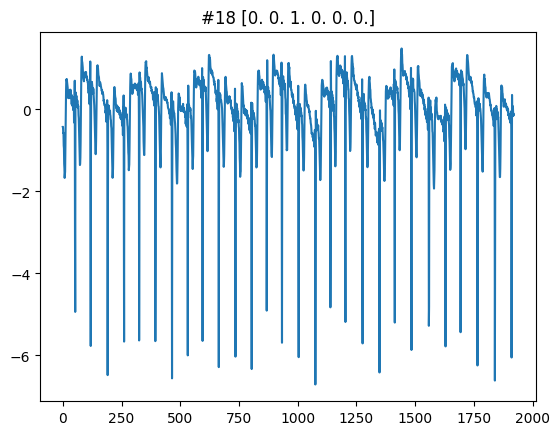

(1920,)


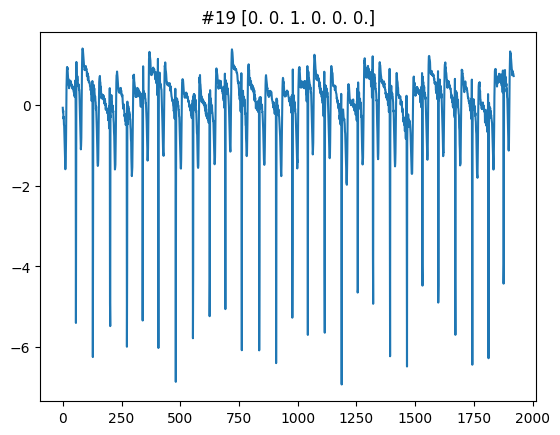

(1920,)


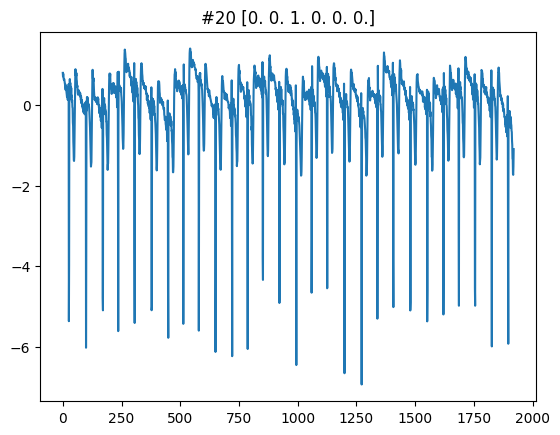

(1920,)


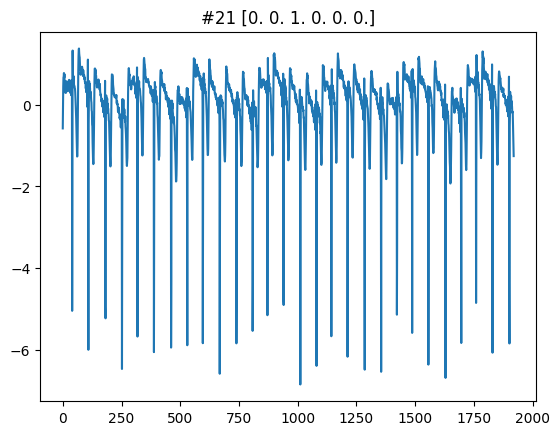

(1920,)


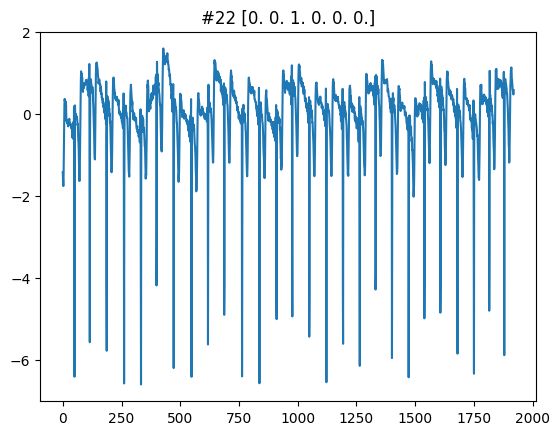

(1920,)


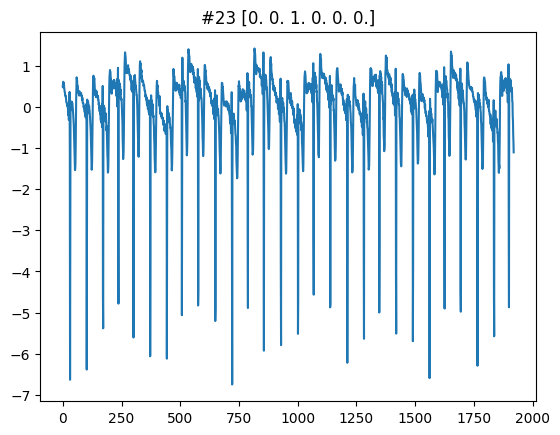

(1920,)


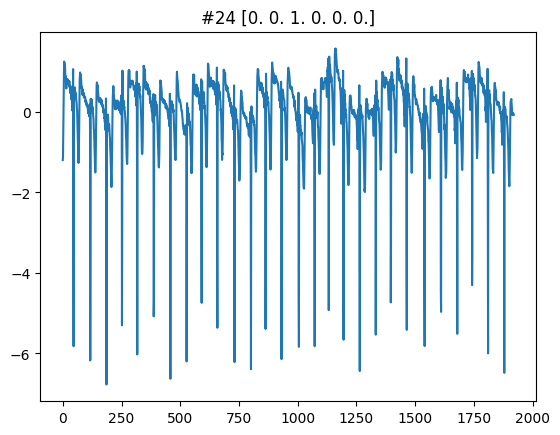

(1920,)


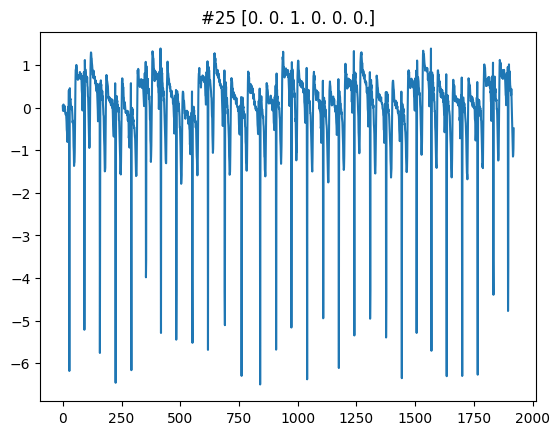

(1920,)


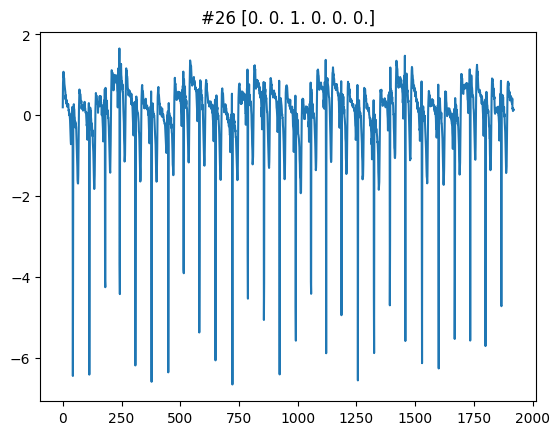

(1920,)


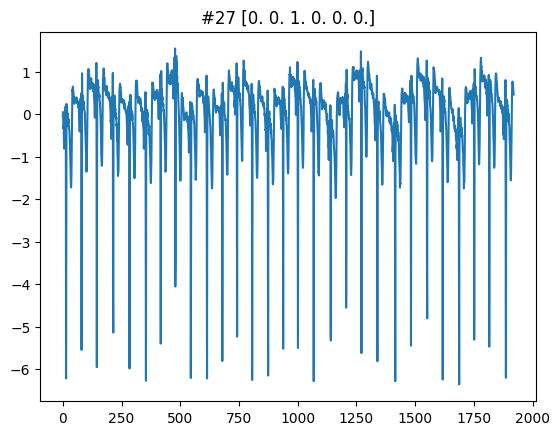

(1920,)


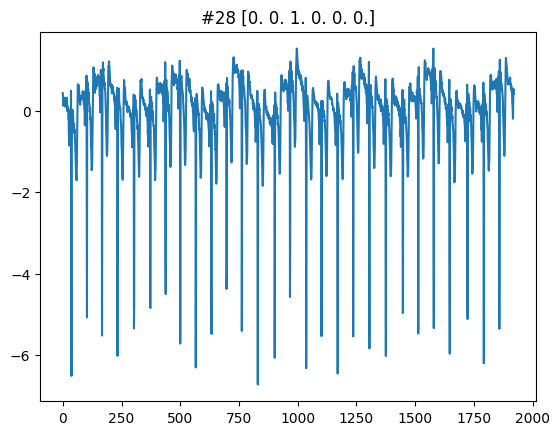

(1920,)


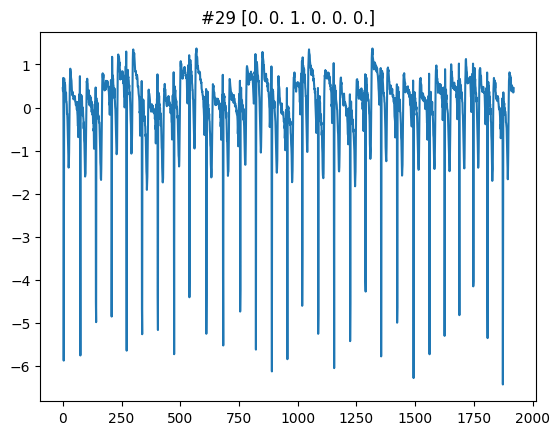

(1920,)


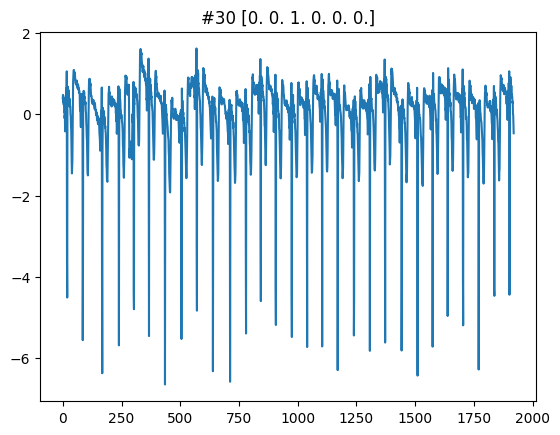

(1920,)


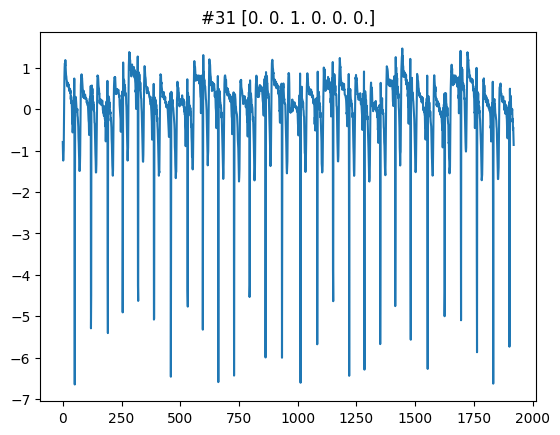

In [30]:
for i in range(batch_x.shape[0]):
    signal = batch_x[i].T[0]
    label = batch_y[i]
    print(signal.shape)
    plt.plot(range(len(signal)), signal)
    plt.title(f"#{i} {label}")
    plt.show()
    # break